## IQA Metrics
CNR and contrast values were saved as the mean value of the slabs for one volume. 
When we display the best configuration results, we are looking at the average of the IQA metrics of volumes for each configuration. We are seeking to find a global metric here.

$$CNR = \frac{{\bar{P}_{\text{object}} - \bar{P}_{\text{background}}}}{{\sqrt{{\sigma^2_{\text{object}} + \sigma^2_{\text{background}}}}}}$$

$$Contrast = \frac{{\bar{P}_{\text{object}} - \bar{P}_{\text{background}}}}{{\bar{P}_{\text{object}} + \bar{P}_{\text{background}}}}$$

### Load your performance metrics CSV file 

All performance metrics are saved in `iqa_metrics-full.csv`. You can change it the file path here. 

In [55]:
import os 
import json 
import pandas as pd 

In [56]:
cur_dir = os.getcwd()
metrics_dir = os.path.join(cur_dir, 'metrics')
csv_filepath = os.path.join(metrics_dir, f'iqa_metrics-full.csv')
df = pd.read_csv(csv_filepath)

 

Be aware that every DICOM file does not the results for all the configurations.  

In [60]:
series_uids_list = df['series_instance_uid']
series_uids_list = set(series_uids_list)

config_list = df['config_hash_code']
config_list = set(config_list)

print('Number of SeriesInstanceUIDs, i.e. DICOM files: ', len(series_uids_list))
print('Number of configurations: ', len(config_list))

# Dictionary of (SeriesInstanceUIDs, configuration hash codes)
dicom_list = {}
for series_instance_uid in series_uids_list:
    df_series_uids = df[df['series_instance_uid'] == series_instance_uid]
    configs = df_series_uids['config_hash_code'].to_list()
    dicom_list[series_instance_uid] = configs

# Save JSON file 
iqa_metrics_filepath = os.path.join(metrics_dir, 'iqa_metrics_dicom_list.json')
with open(iqa_metrics_filepath, 'w') as file:
    json.dump(dicom_list, file, indent=4)

Number of SeriesInstanceUIDs, i.e. DICOM files:  200
Number of configurations:  52



Some CNR and contrast values are negative. These might result from the wrong box coordinates of the images, since some images have up-down flips. Left-right flips were already handled by comparing the view laterality of dataset and also the real image laterality.  

In [59]:
def get_best_result(df: pd.DataFrame, key: str = None):
    idx = df[key].idxmax()
    best_result = df.loc[idx]
    return best_result
    
def get_best_config_result(df: pd.DataFrame, key: str = None):
    df = df[['config_hash_code', key]]
    df_averaged = df.groupby('config_hash_code').mean()
    best_config = df_averaged[key].idxmax()
    best_result = df_averaged.loc[best_config]
    return best_config, best_result

def get_worst_config_result(df: pd.DataFrame, key: str):
    df = df[['config_hash_code', key]]
    df_averaged = df.groupby('config_hash_code').mean()
    worst_config = df_averaged[key].idxmin()
    worst_result = df_averaged.loc[worst_config]
    return worst_config, worst_result
    
def extract_config_iqa(df: pd.DataFrame, config_hash_code: str):
    df = df[df['config_hash_code'] == config_hash_code] 
    df = df[['config_hash_code',
             'projection_method',
             'thickness',
             'overlap',
             'breast_skin_removal',
             'breast_skin_kernel_size',
             'breast_skin_iteration_number']]
    return df.loc[df.index[0]] 


In [4]:
# Filter results with positive IQA metrics 
df = df[df['cnr_mean'] > 0]
df = df[df['contrast_mean'] > 0]

### 1. Best Contrast Result


In [5]:
best_contrast, best_contrast_result = get_best_config_result(df, key='contrast_mean')
display(extract_config_iqa(df, config_hash_code=best_contrast))
print("Best average contrast value: ", best_contrast_result['contrast_mean'])

config_hash_code                118fbb88b272fdcffc902dfdeef0b802
projection_method                                            mip
thickness                                                     14
overlap                                                        7
breast_skin_removal                                            0
breast_skin_kernel_size                                        7
breast_skin_iteration_number                                   1
Name: 29, dtype: object

Best average contrast value:  0.0909017525075395


In [6]:
df_iqa_contrast = df[df['config_hash_code'] == best_contrast]
best_contrast_dicom = get_best_result(df_iqa_contrast, key='contrast_mean')
print('Configuration: ', best_contrast)
print('DICOM file:', best_contrast_dicom['series_instance_uid'])
print("Best contrast value: ", best_contrast_dicom['contrast_mean'])

Configuration:  118fbb88b272fdcffc902dfdeef0b802
DICOM file: 1.2.826.0.1.3680043.8.498.12015914516035206099641097291298835020
Best contrast value:  0.2576273283883763


### 2. Best Contrast-to-Noise Result


In [7]:
best_cnr, best_cnr_result = get_best_config_result(df, key='cnr_mean')
display(extract_config_iqa(df, config_hash_code=best_cnr))
print("Best average CNR value: ", best_cnr_result['cnr_mean'])

config_hash_code                385f7e0f9b5bca242d6e8ad1c1f5fb0f
projection_method                                            mip
thickness                                                     14
overlap                                                        0
breast_skin_removal                                            1
breast_skin_kernel_size                                        7
breast_skin_iteration_number                                   1
Name: 31, dtype: object

Best average CNR value:  0.9948469330399629


In [8]:
df_iqa_cnr = df[df['config_hash_code'] == best_cnr]
best_cnr_dicom = get_best_result(df_iqa_cnr, key='cnr_mean')
print('Configuration: ', best_cnr)
print('DICOM file:', best_cnr_dicom['series_instance_uid'])
print("Best CNR value: ", best_cnr_dicom['cnr_mean'])

Configuration:  385f7e0f9b5bca242d6e8ad1c1f5fb0f
DICOM file: 1.2.826.0.1.3680043.8.498.12015914516035206099641097291298835020
Best CNR value:  3.747803536551833


## Show the Best Configuration Results 

In [9]:
from program.iqa_metrics import IQAMetrics
import yaml 

with open('config/settings.yaml', 'r') as file:
    settings_config = yaml.load(file, Loader=yaml.FullLoader)

with open('config/dataset.yaml', 'r') as file:
    dataset_config = yaml.load(file, Loader=yaml.FullLoader)


# Replace $ROOT$ placeholder by the provided --root value
for config in [settings_config, dataset_config]:
    for cfg in config:
        if isinstance(config[cfg], str) and '$ROOT$' in config[cfg]:
            config[cfg] = config[cfg].replace('$ROOT$', cur_dir)
            
iqa_metrics = IQAMetrics(settings_config=settings_config, dataset_config=dataset_config)
iqa_metrics.init()

### 1. Best Contrast Result

In [10]:
config_hash_code = best_contrast
series_instance_uid = best_contrast_dicom['series_instance_uid']

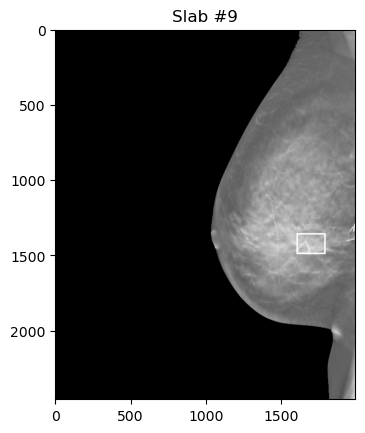

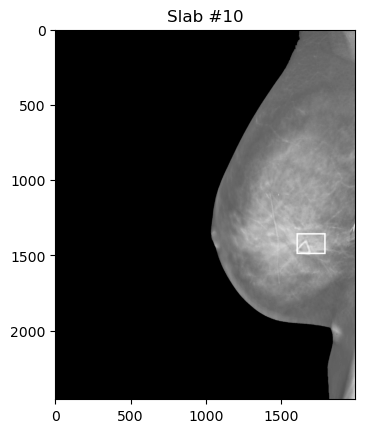

In [11]:
slabs = iqa_metrics.read_slabs(config_hash_code=config_hash_code,
                               series_instance_uid=series_instance_uid)

# Plots with the boxes for pathological regions
iqa_metrics.draw_box_slab(image=slabs,
                          config_hash_code=config_hash_code,
                          series_instance_uid=series_instance_uid,
                          line_width=10)

### 2. Best CNR Result

In [12]:
config_hash_code = best_cnr
series_instance_uid = best_cnr_dicom['series_instance_uid']

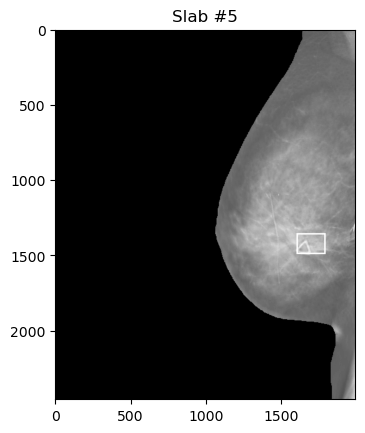

In [13]:
slabs = iqa_metrics.read_slabs(config_hash_code=config_hash_code,
                               series_instance_uid=series_instance_uid)

# Plots with the boxes for pathological regions
iqa_metrics.draw_box_slab(image=slabs,
                          config_hash_code=config_hash_code,
                          series_instance_uid=series_instance_uid,
                          line_width=10)